## <u>*Calssifications Modelling for veh_body as a Target Feature*</u>

In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [2]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )


from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,XGBRFClassifier
import warnings
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,BaggingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
   

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Classification Models to use :*</u>

In [4]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "GradientBoostingClassifier": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "CatBoostClassifier": CatBoostClassifier(verbose=False),
                "AdaBoostClassifier": AdaBoostClassifier(),
                "BaggingClassifier":BaggingClassifier()
            }

#### *A.2. <br> <u>Classification Models spaces preperartion to use in hyperopt :*</u>

In [5]:
space_xgboost_clf  = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

space_rf_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}


space_GradientBoosting_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
}

space_DT = {
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('depth', range(1, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}



space_Bagging_clf = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
}

space_catboost_clf = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'iterations': hp.quniform('iterations', 50, 200, 1),
    'depth': hp.choice('depth', range(1, 15)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}

---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>Solving imbalanced issue if exist :*</u>

In [6]:
print(df5.groupby("veh_body")["veh_body"].count())
print(df5.groupby("veh_body")["veh_body"].count()/df5["veh_body"].count())

veh_body
BUS         48
CONVT       81
COUPE      780
HBACK    18915
HDTOP     1579
MCARA      127
MIBUS      717
PANVN      752
RDSTR       27
SEDAN    22233
STNWG    16261
TRUCK     1750
UTE       4586
Name: veh_body, dtype: int64
veh_body
BUS      0.000707
CONVT    0.001194
COUPE    0.011495
HBACK    0.278752
HDTOP    0.023270
MCARA    0.001872
MIBUS    0.010566
PANVN    0.011082
RDSTR    0.000398
SEDAN    0.327650
STNWG    0.239640
TRUCK    0.025790
UTE      0.067584
Name: veh_body, dtype: float64


> *The data balnance between between veh_age are acceptable*

#### *B.2. <br> <u>LabelEncoding for categorical features :*</u>

In [7]:
df5_2=df5.copy()

In [8]:
LabelEncoder_cat = LabelEncoder()
for col in df5_2:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5_2[col]=LabelEncoder_cat.fit_transform(df5_2[col])

#### *B.3. <br> <u>Define x & y features :*</u>

In [9]:
x=df5_2.drop("veh_body",axis=1)
y=df5_2["veh_body"]

#### *B.4. <br> <u>apply data balance method :*</u>

In [10]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)

#### *B.5. <br> <u>data splitting (training & testing) :*</u>

In [11]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBClassifier:*</u>

In [12]:
def model_XGBClassifier(space_xgboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(space_xgboost_clf['learning_rate']),
               n_estimators=int(space_xgboost_clf['n_estimators']),
               max_depth=int(space_xgboost_clf['max_depth']),
               min_child_weight=int(space_xgboost_clf['min_child_weight']),
               subsample=float(space_xgboost_clf["subsample"]),
               gamma=float(space_xgboost_clf['gamma']),
               colsample_bytree=float(space_xgboost_clf['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [13]:
def model_XGBClassifier_best(best_model_XGBClassifier):
    y_model_XGBClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_XGBClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_XGBClassifier_best Accuracy_result:',  np.mean(Accuracy_list))

In [14]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)


100%|██████████| 10/10 [08:13<00:00, 49.32s/trial, best loss: 0.4194720271252119]


In [15]:
model_XGBClassifier_best(best_model_XGBClassifier)

model_XGBClassifier_best Accuracy_result: 0.7334186762619798


---

#### *C.2 <br> <u>* *RandomForestClassifier:*</u>

In [57]:
def model_rf_clf(space_rf_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(space_rf_clf['n_estimators']),
                                    #criterion=int(space_rf_clf['criterion']),                                                       
                                    max_depth=int(space_rf_clf['max_depth']),
                                    min_samples_split=float(space_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(space_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    #bootstrap=int(space_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [58]:
def model_rf_clf_best(best_model_rf_clf):
    y_model_rf_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
              ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(best_model_rf_clf['n_estimators']),
                                    #criterion=int(best_model_rf_clf['criterion']),                                                       
                                    max_depth=int(best_model_rf_clf['max_depth']),
                                    min_samples_split=float(best_model_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    #bootstrap=int(best_model_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_rf_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_rf_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [59]:
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
model_rf_clf_best(best_model_rf_clf)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:54<00:00,  5.41s/trial, best loss: 0.07574761558777059]
model_rf_clf_best Accuracy_result: 0.07574761558777059


---

#### *C.3 <br> <u>* *GradientBoostingClassifier:*</u>

In [20]:
def model_GradientBoosting_clf(space_GradientBoosting_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(space_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(space_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(space_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(space_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(space_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(space_GradientBoosting_clf['subsample'])

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [21]:
def model_GradientBoosting_clf_best(best_model_GradientBoosting_clf):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(best_model_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(best_model_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(best_model_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(best_model_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(best_model_GradientBoosting_clf['subsample'])


                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_GradientBoosting_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [22]:
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)

100%|██████████| 10/10 [02:13<00:00, 13.33s/trial, best loss: 0.29714594488382373]
model_GradientBoosting_clf_best Accuracy_result: 0.29714594488382373


----

#### *C.4 <br> <u>* *DecisionTreeClassifier:*</u>

In [60]:
def model_DT(space_DT):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(space_DT['criterion']),                                                       
                                    splitter=str(space_DT['splitter']),
                                    max_depth=int(space_DT['max_depth']),
                                    min_samples_split=float(space_DT['min_samples_split']),
                                    min_samples_leaf=float(space_DT['min_samples_leaf']),
                                    #max_features=int(space_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 


In [61]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(best_model_DT['criterion']),                                                       
                                    #splitter=str(best_model_DT['splitter']),
                                    max_depth=int(best_model_DT['depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf']),
                                    #max_features=int(best_model_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_DT_best Accuracy_result:',  np.mean(Accuracy_list))

In [62]:
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 10.03trial/s, best loss: 0.07574761558777059]
model_DT_best Accuracy_result: 0.1512069104706547


---

#### *C.5 <br> <u>* *BaggingClassifier:*</u>

In [81]:
def model_Bagging(space_Bagging_clf):
    base_classifier =DecisionTreeClassifier()
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(               
                                    n_estimators=int(space_Bagging_clf['n_estimators']),
                                    #bootstrap=int(space_Bagging_clf["bootstrap"]),                                                       
                                    #bootstrap_features=int(space_Bagging_clf['bootstrap_features']),
                                    max_samples=float(space_Bagging_clf["max_samples"]),
                                    max_features=float(space_Bagging_clf["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [82]:
def model_Bagging_best(best_model_BaggingClassifier):
    base_classifier =DecisionTreeClassifier()
    y_Bagging_best=[]
    Accuracy_list=[]

    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",BaggingClassifier(                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    #bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    #bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_Bagging_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_Bagging_best Accuracy_result:',  np.mean(Accuracy_list))

In [83]:
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
model_Bagging_best(best_model_BaggingClassifier)

100%|██████████| 10/10 [08:42<00:00, 52.29s/trial, best loss: 0.68776020943616] 
model_Bagging_best Accuracy_result: 0.6268092124231626


---

#### *C.6 <br> <u>* *CatBoostClassifier:*</u>

In [29]:
def model_catboost(space_catboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(space_catboost_clf['learning_rate']),
                                    depth=int(space_catboost_clf["depth"]),                                                       
                                    iterations=int(space_catboost_clf['iterations']),
                                    l2_leaf_reg=float(space_catboost_clf["l2_leaf_reg"]),
                                    border_count=int(space_catboost_clf["border_count"]),
                                    bagging_temperature=float(space_catboost_clf["bagging_temperature"]),
                                    random_strength=float(space_catboost_clf["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [30]:
def model_catboost_best(best_model_catboost):
    y_CatBoostClassifier_best=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_CatBoostClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    print('model_catboost_best Accuracy_result:', Accuracy_result)


In [31]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)
model_catboost_best(best_model_catboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 1.3677055	total: 150ms	remaining: 9s
1:	learn: 1.3518115	total: 163ms	remaining: 4.79s
2:	learn: 1.3358038	total: 173ms	remaining: 3.34s
3:	learn: 1.3212891	total: 182ms	remaining: 2.6s
4:	learn: 1.3092564	total: 191ms	remaining: 2.14s
5:	learn: 1.2986899	total: 201ms	remaining: 1.84s
6:	learn: 1.2866156	total: 210ms	remaining: 1.62s
7:	learn: 1.2755492	total: 223ms	remaining: 1.47s
8:	learn: 1.2672090	total: 232ms	remaining: 1.34s
9:	learn: 1.2572369	total: 242ms	remaining: 1.23s
10:	learn: 1.2496787	total: 252ms	remaining: 1.15s
11:	learn: 1.2431120	total: 260ms	remaining: 1.06s
12:	learn: 1.2344855	total: 270ms	remaining: 996ms
13:	learn: 1.2265370	total: 278ms	remaining: 934ms
14:	learn: 1.2210490	total: 287ms	remaining: 882ms
15:	learn: 1.2137695	total: 295ms	remaining: 830ms
16:	learn: 1.2089527	total: 304ms	remaining: 786ms
17:	learn: 1.2025967	total: 311ms	remaining: 743ms
18:	learn: 1.1983136	total: 319ms	remainin

---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

> *XGBClassifier has the highest accuracy score*

In [16]:
y_XGBClassifier_best=[]
Accuracy_list=[]

XGBClassifier_model =XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])
                                    )

                                                                               
XGBClassifier_model.fit(xtrain,ytrain)
Accuracy_result=accuracy_score(ytest,XGBClassifier_model.predict(xtest))
y_pred=XGBClassifier_model.predict(xtest)
y_XGBClassifier_best.append(y_pred)

Accuracy_result=accuracy_score(ytest,y_pred)
Accuracy_list.append(Accuracy_result)
    

In [17]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6590
           1       0.92      0.96      0.94      6751
           2       0.67      0.74      0.71      6751
           3       0.64      0.63      0.63      6664
           4       0.67      0.73      0.70      6632
           5       0.89      0.92      0.90      6568
           6       0.74      0.86      0.80      6645
           7       0.68      0.85      0.76      6661
           8       0.90      1.00      0.95      6658
           9       0.52      0.40      0.45      6794
          10       0.62      0.42      0.50      6663
          11       0.68      0.63      0.65      6669
          12       0.59      0.46      0.52      6663

    accuracy                           0.73     86709
   macro avg       0.72      0.73      0.72     86709
weighted avg       0.72      0.73      0.72     86709



In [18]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, y_pred),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3,predicted4,predicted5,predicted6,predicted7,predicted8,predicted9,predicted10,predicted11,predicted12
Actual0,6176,7,67,14,19,10,62,40,12,21,32,55,75
Actual1,17,6475,61,59,40,3,6,20,26,24,6,4,10
Actual2,73,254,5007,97,237,56,236,278,79,122,129,75,108
Actual3,80,31,341,4203,108,34,163,384,13,933,47,166,161
Actual4,106,53,172,11,4841,92,282,156,53,96,352,222,196
Actual5,10,41,58,0,56,6070,116,21,37,11,78,30,40
Actual6,63,6,163,36,150,81,5732,124,12,33,81,76,88
Actual7,54,1,205,137,113,34,54,5629,46,151,53,52,132
Actual8,0,0,0,0,4,14,0,0,6636,0,4,0,0
Actual9,82,74,479,1306,342,69,199,623,13,2720,264,243,380


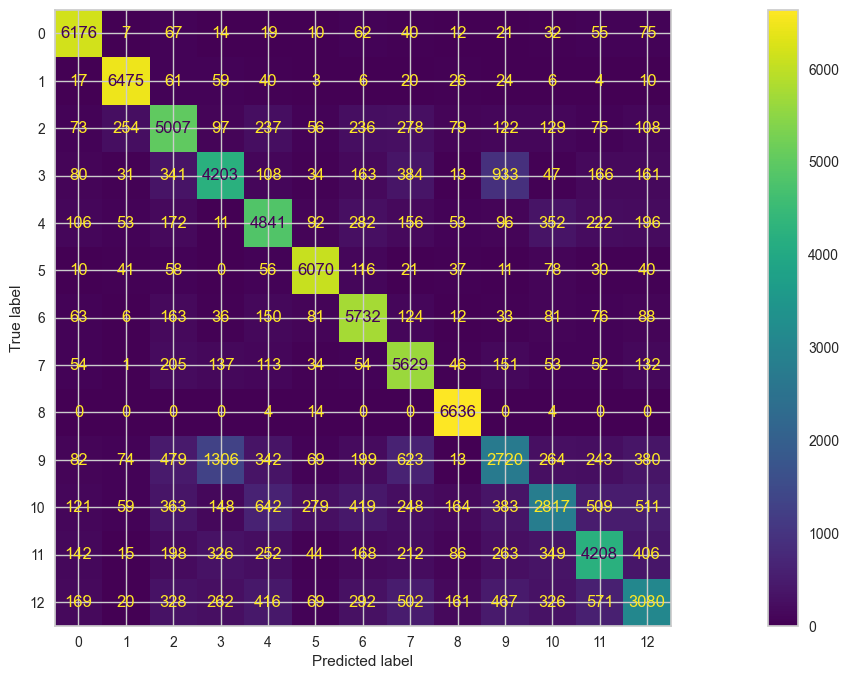

In [19]:
matplotlib.rcParams["figure.figsize"]=(25,8)
ConfusionMatrixDisplay(confusion_matrix(ytest,y_pred)).plot()

In [20]:
df5["veh_body_"]=df5["veh_body"]
pd.concat([df5_2["veh_body"],df5["veh_body_"]],axis=1).groupby(["veh_body","veh_body_"])["veh_body"].unique()

veh_body  veh_body_
0         BUS           [0]
1         CONVT         [1]
2         COUPE         [2]
3         HBACK         [3]
4         HDTOP         [4]
5         MCARA         [5]
6         MIBUS         [6]
7         PANVN         [7]
8         RDSTR         [8]
9         SEDAN         [9]
10        STNWG        [10]
11        TRUCK        [11]
12        UTE          [12]
Name: veh_body, dtype: object

In [21]:
from sklearn.multiclass import OneVsRestClassifier

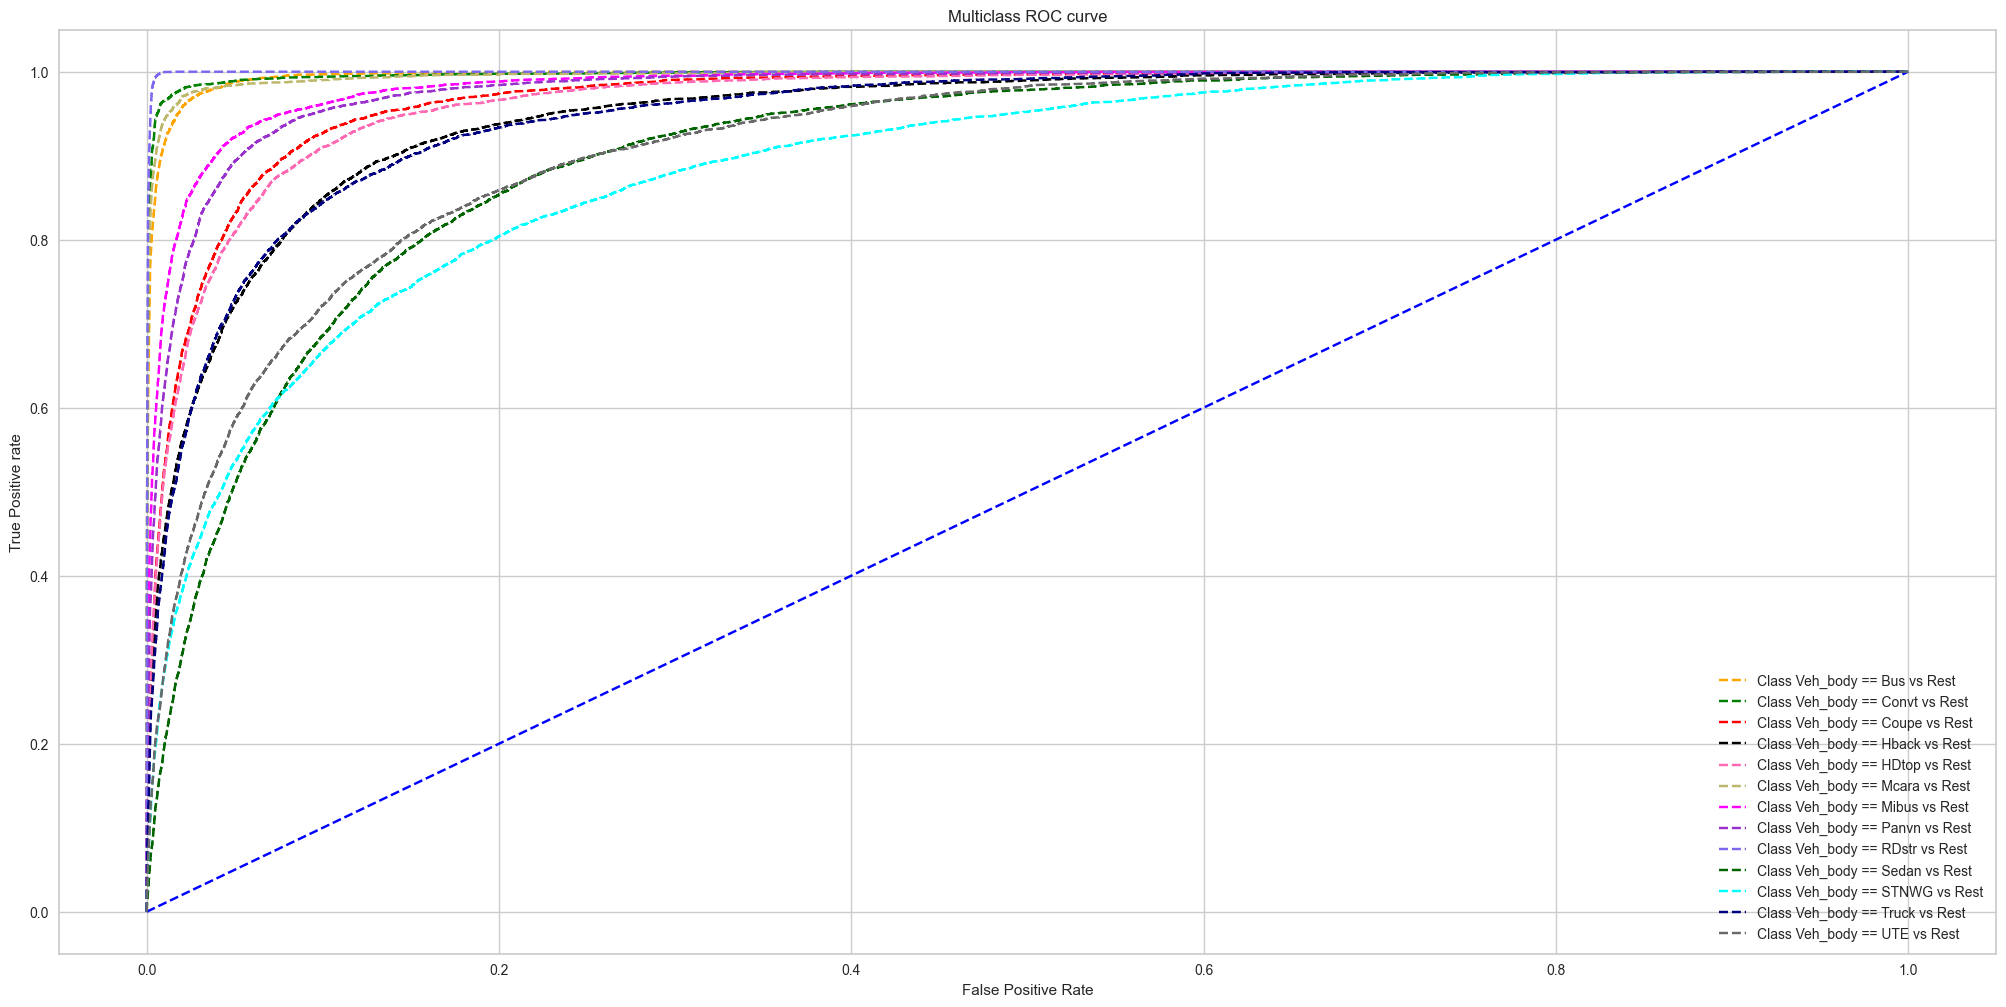

In [22]:
matplotlib.rcParams["figure.figsize"]=(25,12)
clf = OneVsRestClassifier(XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])
                                    ))
                           

clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)
pred_prob = clf.predict_proba(xtest)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 13

random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Veh_body == Bus vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Veh_body == Convt vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class Veh_body == Coupe vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class Veh_body == Hback vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='HotPink', label='Class Veh_body == HDtop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='DarkKhaki', label='Class Veh_body == Mcara vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='Magenta', label='Class Veh_body == Mibus vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='DarkOrchid', label='Class Veh_body == Panvn vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='MediumSlateBlue', label='Class Veh_body == RDstr vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='DarkGreen', label='Class Veh_body == Sedan vs Rest')
plt.plot(fpr[10], tpr[10], linestyle='--',color='Aqua', label='Class Veh_body == STNWG vs Rest')
plt.plot(fpr[11], tpr[11], linestyle='--',color='Navy', label='Class Veh_body == Truck vs Rest')
plt.plot(fpr[12], tpr[12], linestyle='--',color='DimGray', label='Class Veh_body == UTE vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300); 
plt.show()


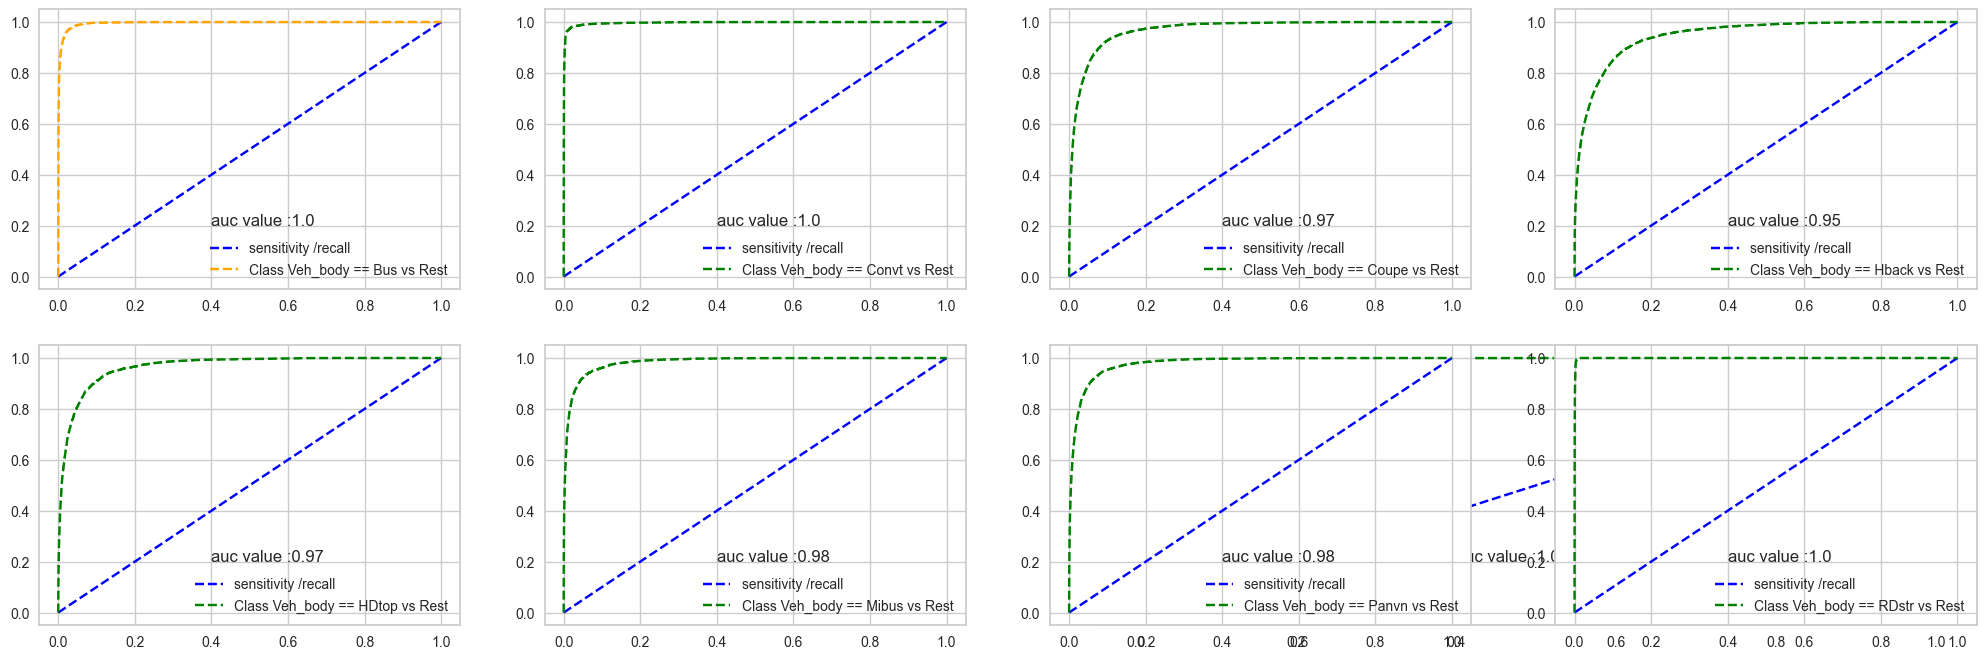

In [23]:
matplotlib.rcParams["figure.figsize"]=(25,8)
plt.subplot(241)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Bus vs Rest'])

plt.subplot(242)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Convt vs Rest'])

plt.subplot(243)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Coupe vs Rest'])

plt.subplot(244)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Hback vs Rest'])

plt.subplot(245)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[4], tpr[4]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == HDtop vs Rest'])

plt.subplot(224)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[5], tpr[5], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[5], tpr[5]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mcara vs Rest'])

plt.subplot(246)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[6], tpr[6], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[6], tpr[6]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mibus vs Rest'])


plt.subplot(247)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[7], tpr[7], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[7], tpr[7]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Panvn vs Rest'])

plt.subplot(248)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[8], tpr[8], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[8], tpr[8]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == RDstr vs Rest'])

plt.show()

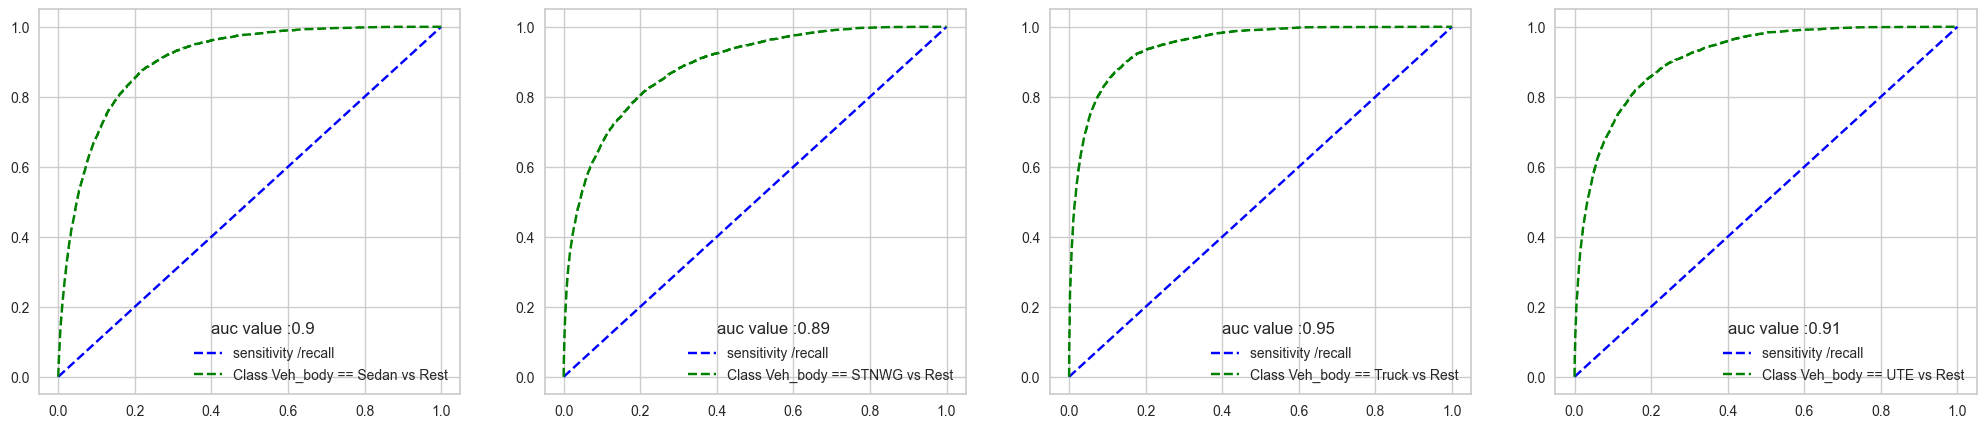

In [29]:
matplotlib.rcParams["figure.figsize"]=(25,5)
plt.subplot(141)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[9], tpr[9], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[9], tpr[9]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Sedan vs Rest'])

plt.subplot(142)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[10], tpr[10], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[10], tpr[10]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == STNWG vs Rest'])


plt.subplot(143)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[11], tpr[11], linestyle='--',color='green')
plt.text(0.4,0.125,f'auc value :{round(auc(fpr[11], tpr[11]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Truck vs Rest'])


plt.subplot(144)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[12], tpr[12], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[12], tpr[12]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == UTE vs Rest'])

plt.show()

---

* *Features Importance*

In [32]:
importance=pd.concat([pd.DataFrame(XGBClassifier_model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(XGBClassifier_model.feature_importances_,columns=["feature_importances"])],axis=1)

In [33]:
Veh_BodyImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
Veh_BodyImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/Veh_BodyImportanceTabel.pkl")

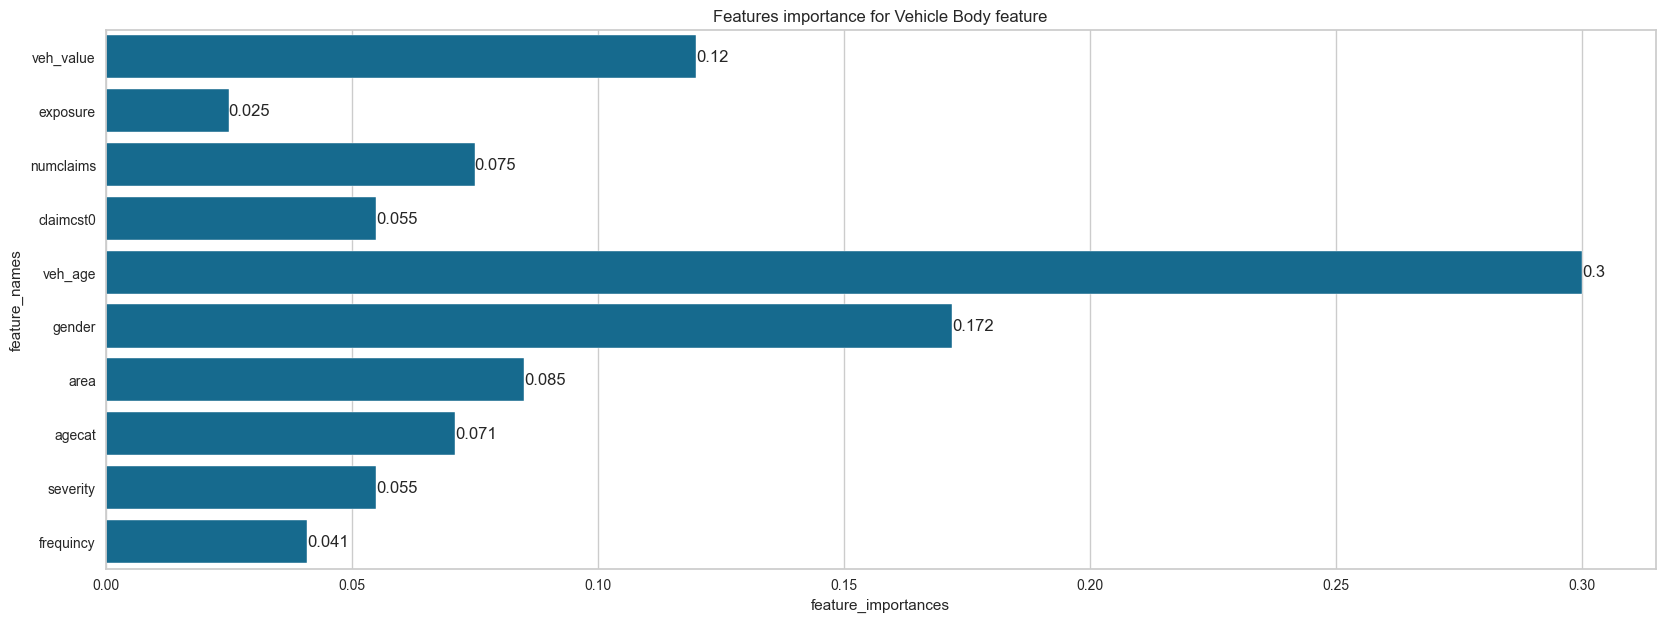

In [34]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Vehicle Body feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Veh_Body_featureImportanc',dpi=500); 

In [30]:
import joblib
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/veh_body_prediction_model_joblib.joblib","wb") as f:
    joblib.dump(XGBClassifier_model,f)

In [31]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/veh_body_prediction_model.pkl","wb") as f:
    pickle.dump(XGBClassifier_model,f)

---